In [1]:
import matplotlib
import matplotlib.path as mplPath
from descartes import PolygonPatch
import numpy as np
import matplotlib.pyplot as plt
import gmplot
import itertools
import requests
import json
import csv
from IPython.core.display import display
from IPython.lib.display import IFrame
import os
import copy
%matplotlib inline
#%matplotlib auto


In [189]:
df1 = pd.read_csv('Postlist.csv', converters={'Postnummer': lambda x: str(x)})

## shp to csv(unused)

In [72]:

# пропускай это, я делал через geoJSON

import ogr,csv,sys # conda install gdal

shpfile=r'./Grensedata_Norge_UTM33_Postsoner/dpg_f.shp' #sys.argv[1]
csvfile=r'./dpg_l.csv' #sys.argv[2]

#Open files
csvfile=open(csvfile,'wb')
ds=ogr.Open(shpfile)
lyr=ds.GetLayer()

#Get field names
dfn=lyr.GetLayerDefn()
nfields=dfn.GetFieldCount()
fields=[]
for i in range(nfields):
    fields.append(dfn.GetFieldDefn(i).GetName())
fields.append('kmlgeometry')
csvwriter = csv.DictWriter(csvfile, fields)
try:csvwriter.writeheader() #python 2.7+
except:csvfile.write(','.join(fields)+'\n')

# Write attributes and kml out to csv
for feat in lyr:
    attributes=feat.items()
    geom=feat.GetGeometryRef()
    attributes['kmlgeometry']=geom.ExportToKML()
    csvwriter.writerow(attributes)

#clean up
del csvwriter,lyr,ds
csvfile.close()

In [21]:
result = []
with open('geocsv_rigth.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        if(spamreader.line_num != 1):
            row[0] = [[float(x.split(' ')[-1]), float(x.split(' ')[0])] for x in row[0].replace('POLYGON ', '')\
                                                                          .replace('(', '')\
                                                                          .replace(")", '')\
                                                                                  .split(',')]
        result.append(row)
#print result[1]#.replace('POLYGON ((', '').replace("))", '')

In [31]:
geoCoord = []
for x in result[1:]:
    el = {
        "type": "Feature",
        "properties": { },
        "geometry":{ 
            "type": "Polygon", 
            "coordinates": [x[0]]
        }
    }
    geoCoord.append(el)

In [32]:
myTOPO = {
    'type': 'FeatureCollection',
    'features':geoCoord
}

In [33]:
with open('node-server/geoJSON/data.json', 'w') as outfile:
    json.dump(myTOPO, outfile)

In [162]:
for (index, val) in enumerate(result):
    print index, val
    break

0 ['WKT', 'POLY_', 'POLY_ID', 'AREA', 'PERIMETER', 'OPPR', 'X', 'Y', 'KOORDH', 'POSTNAVN', 'OPPDATDATO', 'MALEMETODE', 'NOYAKTIGHE', 'SYNBARHET', 'H_MALEMETO', 'H_NOYAKTIG', 'MAX_AVVIK', 'OBJTYPE', 'POSTNR', 'KOMM']


### conda install gdal
### npm install -g topojson
### cmd: ogr2ogr -f geoJSON *name*.json *name*.shp
### cmd: topojson -o *name*.json --id-property SU_A3 *name2*.json

In [34]:
with open("node-server/geoJSON/data.json") as json_file:
    json_data = json.load(json_file, encoding='iso-8859-1')

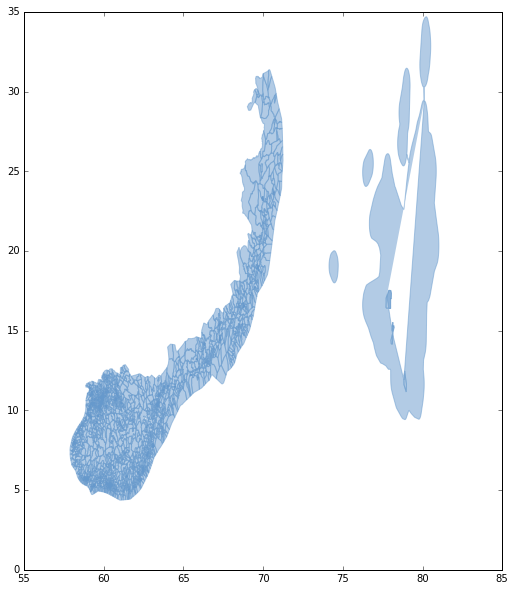

In [38]:
#cid = fig.canvas.mpl_connect('button_press_event', onclick)
deltaC = -1996136.9682796595
deltaX = 37348.34088583822
deltaY = 833761.7935026471

#deltaX = 0#244101 - 59.982262
#deltaY = 0#6.6583e+06 - 10.413351
#59.900170, 10.369229
BLUE = '#6699cc'
fig = plt.figure(figsize=(150,10)) 
ax = fig.gca() 
for i in json_data['features']:
    poly = copy.deepcopy(i['geometry'])
    #poly['coordinates'][0] = [[-(x[0] - deltaC) / deltaX, -(x[1] - deltaC) / deltaY] for x in poly['coordinates'][0]]
    ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
    ax.axis('scaled')

#%matplotlib auto
plt.show()

## Start here

In [225]:
# прорисовка и проверка на коллижины
# TODO: коллижины не по точкам, а по областям, а так же парсинг изоскопа
class PostMatcher(object):
    def __init__(self, points, all_postals = [], time = 9000):
        if not type(points) is list or not type(points[0]) is dict:
            # [float] in case we will change from 1 point to set of points
            print "points should be a list of objects: [{postal: *postalcode*, x: *[float]*, y: *[float]*}]"
            raise Exception(points)
        self.points = points
        self.all_postals = all_postals
        self.time_space = []
        self.time = time
        
    def to_array(self, arr):
        x, y = [], []
        for i in arr:
            d = i.split(',')
            x.append(float(d[0]))
            y.append(float(d[1]))
        return x, y
            
    # thx and soz http://www.flаvіоgоrtаnа.com/isоscоpe/ - don't copy it, there're cyryllic letters
    def getSpace(self, postal, x, y, time): # time in seconds
        # gonna impelement parsing here
        arr = ["59.8720551,10.7900333","59.8720551,10.7913208","59.8722267,10.7918358","59.87257,10.7921791","59.8729134,10.7932091","59.8732567,10.7935524","59.8734283,10.7940674","59.8734283,10.794754","59.8736,10.795269","59.8742867,10.7959557","59.87463,10.7959557","59.8749733,10.7956123","59.8754883,10.7954407","59.8761749,10.7954407","59.8766899,10.7956123","59.8773766,10.796299","59.8775482,10.796814","59.8775482,10.7975006","59.8777199,10.7980156","59.8780632,10.7980156","59.8782349,10.7975006","59.8782349,10.7961273","59.8784065,10.7956123","59.8797798,10.794239","59.8801231,10.794239","59.8814964,10.7956123","59.8816681,10.7961273","59.8816681,10.7975006","59.8818398,10.7980156","59.8821831,10.7983589","59.8823547,10.7988739","59.8823547,10.7995605","59.8825264,10.8000755","59.8835564,10.8004189","59.8838997,10.8007622","59.8844147,10.8009338","59.8849297,10.8007622","59.8859596,10.7997322","59.8864746,10.7995605","59.8871613,10.7995605","59.8876762,10.7997322","59.8880196,10.8007622","59.8883629,10.8011055","59.8885345,10.8016205","59.8885345,10.8023071","59.8887062,10.8028221","59.8890495,10.8028221","59.8893929,10.8024788","59.8904228,10.8021355","59.8907661,10.8017921","59.8912811,10.8016205","59.8919678,10.8016205","59.8924828,10.8014488","59.8928261,10.8011055","59.8933411,10.8009338","59.893856,10.8011055","59.8941994,10.8014488","59.8947144,10.8016205","59.895401,10.8016205","59.895916,10.8017921","59.8966026,10.8024788","59.8967743,10.8029938","59.8967743,10.8050537","59.896946,10.8055687","59.8972893,10.805912","59.8974609,10.806427","59.8974609,10.8078003","59.8976326,10.8083153","59.8979759,10.8086586","59.8983192,10.8096886","59.8986626,10.8100319","59.8990059,10.8110619","59.8993492,10.8114052","59.8995209,10.8119202","59.8995209,10.8139801","59.8993492,10.8144951","59.8990059,10.8148384","59.8986626,10.8158684","59.8981476,10.81604","59.8974609,10.81604","59.896946,10.8158684","59.8966026,10.8148384","59.8962593,10.8144951","59.895916,10.8134651","59.8955727,10.8131218","59.8952293,10.8120918","59.894886,10.8117485","59.8947144,10.8112335","59.8947144,10.8098602","59.8945427,10.8093452","59.8940277,10.8091736","59.8935127,10.8093452","59.8928261,10.8100319","59.8926544,10.8105469","59.8926544,10.8112335","59.8924828,10.8117485","59.8921394,10.8120918","59.8917961,10.8131218","59.8912811,10.8132935","59.8905945,10.8132935","59.8900795,10.8134651","59.8890495,10.8144951","59.8885345,10.8146667","59.8878479,10.8146667","59.8873329,10.8144951","59.8869896,10.8134651","59.8866463,10.8134651","59.8863029,10.8144951","59.8859596,10.8148384","59.885788,10.8153534","59.885788,10.81604","59.8859596,10.816555","59.8863029,10.8168983","59.8864746,10.8174133","59.8864746,10.8194733","59.8863029,10.8199883","59.8859596,10.8203316","59.885788,10.8208466","59.885788,10.8229065","59.8856163,10.8234215","59.885273,10.8237648","59.8851013,10.8242798","59.8851013,10.8249664","59.8849297,10.8254814","59.8845863,10.8258247","59.884243,10.8268547","59.883213,10.8278847","59.8830414,10.8283997","59.8830414,10.8290863","59.8828697,10.8296013","59.8825264,10.8299446","59.8823547,10.8304596","59.8825264,10.8309746","59.8845863,10.8330345","59.8851013,10.8332062","59.8856163,10.8330345","59.8859596,10.8326912","59.8864746,10.8325195","59.8885345,10.8325195","59.8890495,10.8323479","59.8893929,10.8320045","59.8899078,10.8318329","59.8905945,10.8318329","59.8911095,10.8320045","59.8914528,10.8330345","59.8917961,10.8333778","59.8919678,10.8338928","59.8919678,10.8345795","59.8917961,10.8350945","59.8914528,10.8354378","59.8912811,10.8359528","59.8912811,10.8366394","59.8911095,10.8371544","59.8900795,10.8381844","59.8897362,10.8392143","59.8890495,10.839901","59.8885345,10.8400726","59.8880196,10.839901","59.8869896,10.838871","59.8864746,10.8386993","59.885788,10.8386993","59.885273,10.838871","59.8845863,10.8395576","59.884243,10.8405876","59.883213,10.8409309","59.8830414,10.8414459","59.8830414,10.8421326","59.8828697,10.8426476","59.8818398,10.8429909","59.8814964,10.8433342","59.8809814,10.8435059","59.8796082,10.8435059","59.8790932,10.8433342","59.8784065,10.8426476","59.8782349,10.8421326","59.8782349,10.8366394","59.8784065,10.8361244","59.8790932,10.8354378","59.8801231,10.8350945","59.8801231,10.8347511","59.8797798,10.8344078","59.8796082,10.8338928","59.8796082,10.8332062","59.8794365,10.8326912","59.8790932,10.8326912","59.8784065,10.8333778","59.8780632,10.8344078","59.8775482,10.8345795","59.8768616,10.8345795","59.8763466,10.8344078","59.8756599,10.8337212","59.8754883,10.8332062","59.8754883,10.8325195","59.8753166,10.8320045","59.8749733,10.8320045","59.8748016,10.8325195","59.8748016,10.8345795","59.87463,10.8350945","59.8742867,10.8354378","59.8739433,10.8364677","59.8734283,10.8366394","59.8727417,10.8366394","59.8722267,10.8364677","59.8718834,10.8361244","59.8715401,10.8361244","59.8708534,10.8368111","59.8706818,10.837326","59.8706818,10.8380127","59.8705101,10.8385277","59.8699951,10.8386993","59.8693085,10.8386993","59.8687935,10.8385277","59.8681068,10.837841","59.8679352,10.837326","59.8679352,10.8345795","59.8677635,10.8338928","59.8672485,10.8333778","59.8665619,10.8332062","59.8658752,10.8332062","59.8653603,10.8333778","59.8633003,10.8354378","59.8631287,10.8359528","59.8631287,10.837326","59.862957,10.837841","59.862442,10.8380127","59.8610687,10.8380127","59.8605537,10.837841","59.8603821,10.837326","59.8603821,10.8345795","59.8602104,10.8340645","59.8596954,10.8338928","59.8590088,10.8338928","59.8584938,10.8340645","59.8581505,10.8344078","59.8571205,10.8347511","59.8567772,10.8350945","59.8557472,10.8354378","59.8554039,10.8357811","59.8543739,10.8361244","59.8540306,10.8364677","59.8530006,10.8368111","59.8526573,10.8371544","59.8516273,10.8374977","59.8505974,10.8385277","59.8495674,10.838871","59.8492241,10.8392143","59.8487091,10.839386","59.8481941,10.8392143","59.8475075,10.8385277","59.8473358,10.8380127","59.8473358,10.8345795","59.8475075,10.8340645","59.8485374,10.8330345","59.8487091,10.8325195","59.8487091,10.8290863","59.8488808,10.8285713","59.8493958,10.8283997","59.8500824,10.8283997","59.8505974,10.8285713","59.851284,10.829258","59.8514557,10.8297729","59.8514557,10.8304596","59.8516273,10.8309746","59.8521423,10.8311462","59.8526573,10.8309746","59.8530006,10.8306313","59.8540306,10.8302879","59.8543739,10.8299446","59.8554039,10.8296013","59.8557472,10.829258","59.8567772,10.8289146","59.8571205,10.8285713","59.8576355,10.8283997","59.8583221,10.8283997","59.8588371,10.828228","59.8590088,10.827713","59.8590088,10.8263397","59.8591805,10.8258247","59.8602104,10.8247948","59.8603821,10.8242798","59.8603821,10.8229065","59.8602104,10.8223915","59.8598671,10.8220482","59.8596954,10.8215332","59.8596954,10.8208466","59.8595238,10.8203316","59.8591805,10.8199883","59.8590088,10.8194733","59.8591805,10.8189583","59.8595238,10.818615","59.8596954,10.8181","59.8596954,10.8174133","59.8595238,10.8168983","59.8591805,10.816555","59.8590088,10.81604","59.8590088,10.8119202","59.8591805,10.8114052","59.8598671,10.8107185","59.8603821,10.8105469","59.8608971,10.8107185","59.8615837,10.8114052","59.861927,10.8124352","59.8622704,10.8124352","59.862442,10.8119202","59.862442,10.8078003","59.8626137,10.8072853","59.8636436,10.8062553","59.8638153,10.8057404","59.8638153,10.8036804","59.863987,10.8031654","59.8646736,10.8024788","59.8657036,10.8021355","59.8660469,10.8011055","59.8670769,10.8000755","59.8672485,10.7995605","59.8672485,10.796814","59.8674202,10.796299","59.8677635,10.7959557","59.8681068,10.7949257","59.8691368,10.7945824","59.8693085,10.7940674","59.8693085,10.7899475","59.8694801,10.7894325","59.8699951,10.7892609","59.8713684,10.7892609","59.8718834,10.7893467","59.8720551,10.7896042","59.8720551,10.7900333"]
        lat, lon = self.to_array(arr)
        return {'postal': postal, 'x': x, 'y': y, 'dest_lat': lat, 'dest_lon': lon}
                
    # checking whether there's collision
    # element: {postal: string, dest_lat: [float], dest_lon: [float]}
    # check_with: [{postal: string, x: float, y: float}]
    def check_collision(self, element, check_with):
        result = {'postal': element['postal'], 'intersects': [], 'nonintersect': []}
        # getting our path Area
        path_data = []
        path_data.append((mplPath.Path.MOVETO, (element['dest_lat'][0], element['dest_lon'][1])))
        for x, y in itertools.izip(element['dest_lat'][1:], element['dest_lon'][1:]):
            path_data.append((mplPath.Path.LINETO, (x, y)))
        # closing our rectangle
        path_data.append((mplPath.Path.LINETO, (element['dest_lat'][0], element['dest_lon'][0])))
        # formating it for matplotlib.Path
        codes, verts = zip(*path_data)
        path = mplPath.Path(verts, codes)
        # checking intersections
        for i, val in enumerate(check_with):
            if path.contains_point((val['x'], val['y'])):
                # should add check for dublicates
                result['intersects'].append(val)
            else:
                result['nonintersect'].append(val)
        return result
        
    
    def draw(self, areas, elements, markers = [], **kwargs):
        fileName = kwargs.get('fileName',"map.html")
        x = y = None
        #for currEl, nextEl in zip(the_list, the_list[1:]):
        for el in elements:
            avgX = np.average(el['dest_lat'])
            avgY = np.average(el['dest_lon'])
            if x is None:
                x, y = avgX, avgY
            else:
                x, y = np.average([x, avgX]), np.average([y, avgY])
        
        zoomLevel = kwargs.get('zoomLevel', 12)
        gmap = gmplot.GoogleMapPlotter(x, y, zoomLevel)
        
        colorTypes = [
            'cornflowerblue'
            #'khaki',
            #'forestgreen'
        ]
        colorCounter = 0
        colorTypesLength = len(colorTypes) - 1
        
        areaColors = [
            'khaki'
        ]
        areaCC = 0
        areaCL = len(colorTypes) - 1  
        
        for element in elements:
            gmap.polygon(element['dest_lat'], element['dest_lon'], colorTypes[colorCounter], edge_width=10)
            gmap.marker(np.average(element['dest_lat']), np.average(element['dest_lon']), title=element['postal'])
            colorCounter += 1
            if colorCounter> colorTypesLength:
                colorCounter = 0
        for area in areas:
            gmap.polygon(area['dest_lat'], area['dest_lon'], areaColors[areaCC], edge_width=10)
            gmap.marker(np.average(area['dest_lat']), np.average(area['dest_lon']), title=area['postal'])
            areaCC += 1
            if areaCC > areaCL:
                areaCC = 0
        # drawing needed markers
        for i in markers:
            print i
            gmap.marker(i['x'], i['y'], title=i['postal'])
        gmap.draw(fileName)
        # проблема в правах доступа и маркер не подтягивает(он находится в папке с библиотекой, а Chrome не дает к ней доступ)
        data = []
        with open(fileName, 'r') as f:
            #https://developers.google.com/maps/documentation/javascript/infowindows
            data = f.read().replace("icon: img,", 'icon: "",').replace("title: ", 'label: ')
        os.remove(fileName)
        with open(fileName, 'a') as f:
            f.write(data)
        display(IFrame(fileName, height = 500, width = "90%"))


    def renderSingle(self, postal, x, y, time, re_render = False):
        # don't use that func often, plx, or use it only when you're SURE (it's parsing site)
        for i, val in enumerate(self.time_space):
            if val['postal'] == postal:
                if not re_render: 
                    break
                self.time_space[i] = self.getSpace(postal, x, y, time)
                break
            else:
                self.time_space.append(self.getSpace(postal, x, y, time))
                
        if len(self.time_space) == 0:
            self.time_space.append(self.getSpace(postal, x, y, time))
            
        return 0
    
    def renderAll(self, re_render = False): # time = 2.5 hours
        for i in self.points:
            self.renderSingle(i['postal'], i['x'][0], i['y'][0], self.time, re_render)
        return self.time_space

In [233]:
# parsing our data points
def getPostalZones():
    postalZones = []
    with open('geocsv_rigth.csv', 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in spamreader:
            if(spamreader.line_num == 1):
                continue
            coords = row[0].replace('POLYGON ', '').replace('(', '').replace(")", '').split(',')
            x, y = [], []
            for el in coords:
                el = el.split(' ')
                x.append(float(el[-1]))
                y.append(float(el[0]))
            point = {
                'postal': row[-2],
                'dest_lat': x,
                'dest_lon': y
            }
            postalZones.append(point)
    return postalZones

In [234]:
# эти функции нужно будет закинуь в класс
def readUrl(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1)'\
            + ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
    }
    page = requests.get(url, headers=headers)
    return page.content

def location(postcode):
    url = "http://maps.googleapis.com/maps/api/geocode/json?components=country:NO%7Cpostal_code:"\
          + postcode\
          + "&sensor=false"
    print url
    response = readUrl(url)
    data = json.loads(response)
    bounds = data['results'][0]["geometry"]['bounds']
    # creating Rhombus
    latitudes =  [
        (bounds['northeast']['lat'] + bounds['southwest']['lat'])/2,
        bounds['northeast']['lat'],
        (bounds['northeast']['lat'] + bounds['southwest']['lat'])/2,
        bounds['southwest']['lat']
    ]
    longitudes =  [
        bounds['southwest']['lng'],
        (bounds['northeast']['lng'] + bounds['southwest']['lng'])/2,
        bounds['northeast']['lng'],
        (bounds['northeast']['lng'] + bounds['southwest']['lng'])/2
    ]
   
    return latitudes, longitudes

# testing
# нужно бы ещё парсинг добавить и будет гуд
#latitudes = 59.87349399999999
#longitudes = 10.8140581
latitudes, longitudes = location("3684")
#####################################################################
# должен использоваться для выкачки с изоскоупа, сейчас не работает(принимал точку с latitudes, longitudes(центральную))
# как вариант в будущем просто изменить на точки от зайца)
#####################################################################
points = [{
        'postal' : 'TEST',
        'x' : latitudes,
        'y' : longitudes
    }]
check_with = [{
        'postal' : 'COLLISION_TRUE',
        'x': latitudes[0],
        'y': longitudes[0]
    },{
        'postal' : 'COLLISION_FALSE',
        'x': latitudes[0] + 50,
        'y': longitudes[0] + 50
    }]
postalZones = getPostalZones()

http://maps.googleapis.com/maps/api/geocode/json?components=country:NO%7Cpostal_code:3684&sensor=false


In [235]:
# DRAWING
test_single = PostMatcher(points)
test_single.renderAll()

# проверяем есть ли эти точки попадают в нашу зону.
# Это нужно ещё поправить

collisions_test = test_single.check_collision(test_single.time_space[0], check_with)

# рисуем
test_single.draw(test_single.time_space[0:1], postalZones[0:1], collisions_test['intersects'], fileName='mymap.html')

# sometimes image just won't show - experiment with file name: change it to random and try again
# if that don't work try it over and over again)
# error(f12->console): 
# Google Maps API error: MissingKeyMapError https://developers.google.com/maps/documentation/javascript/error-messages#missing-key-map-error_.jb @ js?libraries=visualization&sensor=true_or_false:34
